In [22]:
%matplotlib ipympl

import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [23]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [24]:
def ah_height_from_data(transmissions_avg, monitors_avg, headers):
    antihole_heights_1_avg = transmissions_avg["antihole"]
    antihole_heights_2_avg = transmissions_avg["antihole_delay"]
    detunings = headers["detunings"].to("MHz").magnitude
    off_resonant_index = np.argmax(np.abs(detunings) > 0)
    on_resonant_index = 1 - off_resonant_index
    heights = {}
    heights["antihole_heights_1"] = 1 - antihole_heights_1_avg[on_resonant_index] / antihole_heights_1_avg[off_resonant_index]
    heights["antihole_heights_2"] = 1 - antihole_heights_2_avg[on_resonant_index] / antihole_heights_2_avg[off_resonant_index]
    return heights

In [25]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    antihole_heights_1 = []
    antihole_heights_2 = []
    headers = []
    for data_number in data_numbers:
        transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
        heights = ah_height_from_data(transmissions_avg, monitors_avg, headers_single)
        headers.append(headers_single)
        antihole_heights_1.append(heights["antihole_heights_1"])
        antihole_heights_2.append(heights["antihole_heights_2"])
    return antihole_heights_1, antihole_heights_2, headers

In [26]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

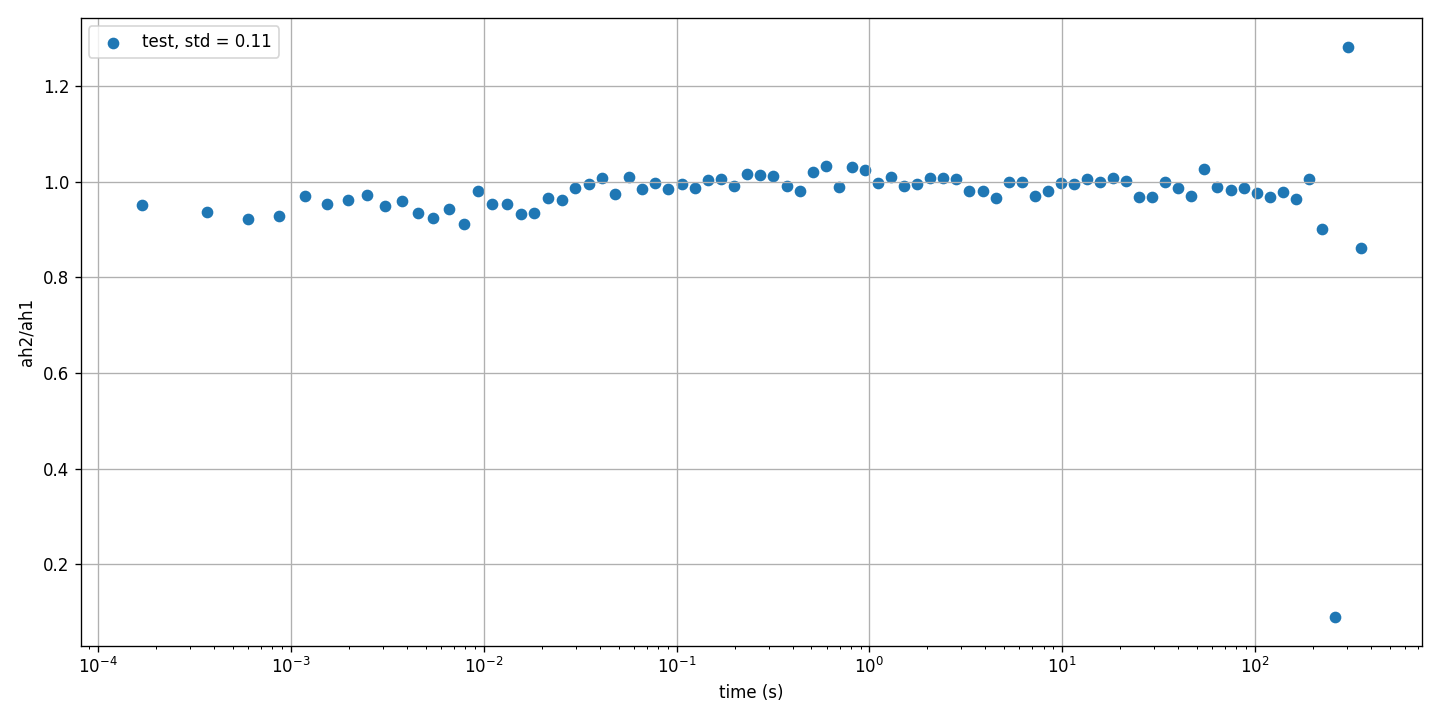

In [39]:
data = {
    "test": (109344, 109426),
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    antihole_heights_1, antihole_heights_2, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["detect"]["delta_detect_time"].to("s").magnitude for header in headers]
    xs = [kk - xs[0] for kk in xs]
    ys = [antihole_heights_2[i] / antihole_heights_1[i] for i in range(len(antihole_heights_1))]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")

ax.set_xscale("log")
ax.set_xlabel("time (s)")
ax.set_ylabel("ah2/ah1")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()